<a href="https://colab.research.google.com/github/usef-kh/SpeechRecognition/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load Kaggle API Token
from google.colab import files
!pip install -q kaggle > /dev/null
uploaded = files.upload()
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Load Data
!kaggle competitions download -c tensorflow-speech-recognition-challenge > /dev/null

# # Unzip Data
# !apt-get install p7zip-full > /dev/null
!p7zip -d train.7z


Saving kaggle.json to kaggle.json
100% 50.0/50.0 [00:00<00:00, 79.5kB/s]
100% 2.46G/2.46G [00:37<00:00, 70.8MB/s]
100% 1.04G/1.04G [00:26<00:00, 42.3MB/s]
100% 501k/501k [00:00<00:00, 70.1MB/s]

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 39 - train/audio/_background_noise_/dude_miaowing.wav                                                            0% 41 - train/audio/_background_noise_/pink_noise.wav

<!-- ## Useful Imports and Functions -->

In [5]:
import librosa
import librosa.display
from scipy import signal
import numpy as np
from keras import backend as K
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
import time
from IPython.display import Audio
from os import walk
from matplotlib import pyplot as plt
import csv
import keras
import random
import collections
import IPython.display as ipd

### Loading Data Helper funcitons

In [6]:
def fixSize(data, nsamples=16000):
    maxID = np.argmax(np.abs(data))
    leftVal = data[0]
    rightVal = data[-1]
    ptr = maxID - nsamples//2
    res = []
    while ptr < 0:
        res.append(leftVal)
        ptr += 1

    while len(res) < nsamples and ptr < len(data):
        res.append(data[ptr])
        ptr += 1

    while len(res) < nsamples:
        res.append(rightVal)
    
    data = np.array(res).astype(np.float16)
        
    return data

In [7]:
def generateFiles():
    train_audio_path = '/content/train/audio/'

    # Load all filenames into a dictionary so we can call on them easily
    files = {}
    for (dirpath, dirnames, filenames) in walk(train_audio_path):
        files[dirpath[21:]] = filenames

    files.pop('')
    files['_background_noise_'].remove('README.md')

    return files

In [8]:
import librosa
import scipy.signal as sps
import random


def manipulatePitch(data, pitch_factor):
    return librosa.effects.pitch_shift(data.astype(np.float32), 16000, pitch_factor)

def stretch(data, rate=1):
    input_length = 16000
    data = librosa.effects.time_stretch(data.astype(np.float32), rate)
    return fixSize(data)

In [9]:
def get_wav(file_name, nsamples=16000, orig=False):
    wav = wavfile.read(file_name)[1]

    if orig:
        return wav
    else:
        return fixSize(wav)

    # if wav.size < nsamples:
    #     audio = np.pad(wav, (nsamples - wav.size, 0), mode='constant')
    # else:
    #     audio = wav[0:nsamples]
    # return audio

def get_noise(filename, nsamples=16000, stepSize = 2000):
    wav = wavfile.read(filename)[1]

    noise = []
    for i in range((len(wav)-nsamples) // stepSize):
        start = i*stepSize
        subsample = wav[start: start + nsamples]
      
        if len(subsample) < nsamples:
            subsample = np.pad(wav, (nsamples - subsample.size, 0), mode='constant')
        noise.append(subsample)
    
    return noise

In [10]:
def loadData(files, sample=None):
    train_audio_path = '/content/train/audio/'
    labels = set(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'])

    noiseChunks = []
    for filename in files['_background_noise_']:
        noise = get_noise(train_audio_path + '_background_noise_' + '/' + filename)
        noiseChunks.append(noise)
        
    files.pop('_background_noise_')

    choices = [0.8, 1.2]
    
    if sample:
        sampleIdx = random.randint(0, len(files[sample]) - 1)
        orig = get_wav(train_audio_path + sample + '/' + files[sample][sampleIdx], orig=True)
        fixed = fixSize(orig)
        
        chunkID = random.randint(0, len(noiseChunks) - 1)
        noiseSampleId = random.randint(0, len(noiseChunks[chunkID]) - 1)
        noisy = fixed + noiseChunks[chunkID][noiseSampleId]*random.random()/10

        stretched = stretch(fixed, choices[random.randint(0, 1)])

        return (orig, fixed, noisy, stretched)

    print("Loading and augmenting all classes") 
    xtrain, ytrain = [], []
    for label in ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']:
        
        for i, filename in enumerate(files[label]):
            audio = get_wav(train_audio_path + label + '/' + filename)
            xtrain.append(audio)
            ytrain.append(label)

            # if random.random() > 0.5:
            #     # Data Augmentation thorugh adding noise           
            #     chunk = noiseChunks[i % 6]
            #     idx = random.randint(0, len(chunk) - 1)
            #     noisy = audio + chunk[idx]*random.random()/10
                
            #     xtrain.append(noisy)
            #     ytrain.append(label)

            # if random.random() > 0.5:
            #     # Data Augmentation though changing speed
            #     streched = stretch(audio, choices[i % 2])
            #     xtrain.append(streched)
            #     ytrain.append(label)

            # print(i)
        files.pop(label)

    print("Loading 'unknown' class")
    for label, filenames in files.items():
        for filename in filenames:
            audio = get_wav(train_audio_path + label + '/' + filename)
            xtrain.append(audio)
            ytrain.append('unknown')

    print("Adding 'silence' class")
    for chunk in noiseChunks:
        xtrain.extend(chunk)
        ytrain.extend(['silence']*len(chunk))
    
    return np.array(xtrain, dtype=np.float16), np.array(ytrain)


### Preprocessing

In [11]:
def onehot(A, mapping=None):
  labels = set(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown'])

  if mapping is None:
    mapping = {}
    maptolable = {}
    for i, label in enumerate(labels):
      temp = [0] * len(labels)
      temp[i] = 1
      mapping[label] = temp
      maptolable[i] = label
      
  res = []
  for label in A:
    res.append(mapping[label])
  
  return np.array(res), mapping, maptolable

### Other Functions

In [12]:
def f1(y_true, y_pred):
  """Macro F1 Score

  A custom metric function that computes the average of the f1 scores 
  across all classesin a multiclass classificaiton problem
  """
  def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)
  return 2*((precision * recall)/(precision + recall + K.epsilon()))

In [13]:
def swish(x, beta = 1):
    return (x * K.sigmoid(beta * x))

# Getting the Custom object and updating them 
from keras.utils.generic_utils import get_custom_objects 
from keras.layers import Activation 
  
# Below in place of swish you can take any custom key for the name  
get_custom_objects().update({'swish': Activation(swish)}) 

In [14]:
def performance_curves(history, metrics):
  def generate_plot(metric):
    train = history.history[metric]
    val = history.history['val_' + metric]
    x_axis = range(1, len(history.history[metric])+1)

    plt.figure()
    plt.plot(x_axis, train, label="Training " + metric)
    plt.plot(x_axis, val, label="Validation " + metric)

    plt.ylabel(metric)
    plt.xlabel('Epochs')
    plt.title('Epochs vs ' + metric)
    plt.legend()
    plt.show()

    if metric == 'loss':
      print('Minimum Validation Loss is:', str(min(val)))
      print('Epoch: ', str(val.index(min(val)) + 1))
    else:
      print('Maximum', metric, 'is:', str(max(val)))
      print('Epoch: ', str(val.index(max(val)) + 1))
  
  for metric in metrics:
    generate_plot(metric)

In [15]:
def log_specgram(audio, sample_rate=16000, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

## Studying Dataset

In [42]:
files = generateFiles()

# Loading a random sample and all its augmentations
orig, fixed, noisy, stretched = loadData(files, sample='yes')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: WavFileWarning: Chunk (non-data) not understood, skipping it.
  app.launch_new_instance()


(99, 13) (99, 161) (99, 32) (99, 32) (7, 32)


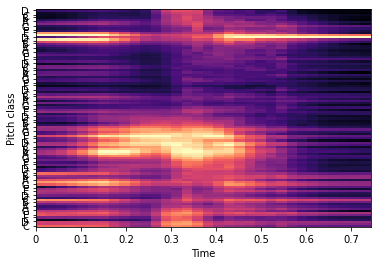

In [57]:
# !pip install python_speech_features
from python_speech_features import mfcc as MFCC

# MFCC
mfcc = MFCC(orig)

# Log Mel Spectogram
_, spectrogram = log_specgram(orig)

# Chroma
chroma_stft = librosa.feature.chroma_stft(orig.astype(float), sr=16000, n_chroma=99, n_fft=4096)
chroma_cq = librosa.feature.chroma_cqt(orig.astype(float), sr=16000, n_chroma=99)

# Spectral Contrast
S = np.abs(librosa.stft(orig.astype(float)))
contrast = librosa.feature.spectral_contrast(S=S, sr=16000)

# plt.figure()
# plt.imshow(spectrogram.T, aspect='auto', origin='lower')
# plt.axis('off')
# plt.figure()
# plt.imshow(contrast, aspect='auto', origin='lower')
# plt.axis('off')

plt.figure()
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')

print(mfcc.shape, spectrogram.shape, chroma_stft.shape, chroma_cq.shape, contrast.shape)

Text(0.5, 1.0, 'streched')

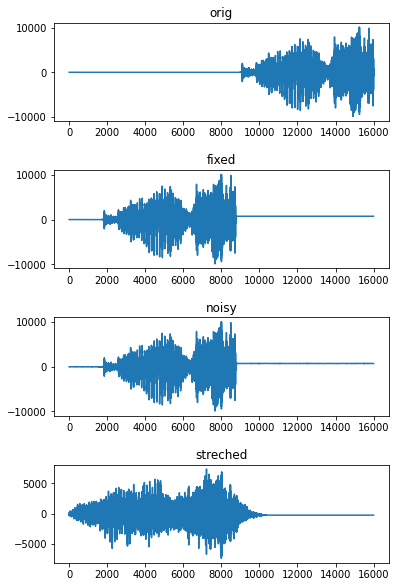

In [19]:
#figure, axes = plt.subplots(4)
figure.subplots_adjust(top=2, hspace=0.5)
axes[0].plot(orig)
axes[0].set_title('orig')
axes[1].plot(fixed)
axes[1].set_title('fixed')
axes[2].plot(noisy)
axes[2].set_title('noisy')
axes[3].plot(stretched)
axes[3].set_title('stretched')

# ipd.Audio(orig, rate=16000)
# ipd.Audio(fixed, rate=16000)
# ipd.Audio(noisy, rate=16000)
# ipd.Audio(stretched, rate=16000)

### Loading samples

In [ ]:
files = generateFiles()
X, Y = loadData(files)

debug = True
if debug:
 
  print(len(X), len(Y))
  
  count = 0
  for label, samples in files.items():
    print(label, '\t', len(samples))
    count += len(samples)

  print("Number of Audio signals:", count)

In [ ]:
import collections

print(len(X), len(Y))

count = collections.defaultdict(int)
for y in Y:
    count[y] += 1

for label, c in count.items():
    print(label, c)
    

In [ ]:
Xfinal = X.reshape(-1, 16000, 1)

Yonehot, mapping, maptolable = onehot(Y)
Yonehot = Yonehot.reshape(-1, 1, 12)

xtrain, xval, ytrain, yval = train_test_split(Xfinal, Yonehot, test_size=0.2, random_state=127)

print('Number of Dimensions:', X.ndim)
print('Dataset')
print('\t', Xfinal.shape, '\t', Yonehot.shape)

print('\nTraining Data')
print('\t', xtrain.shape, '\t', ytrain.shape)

print('\nValidation Data')
print('\t', xval.shape, '\t', yval.shape)

In [ ]:
def printCount(labels):
    count = collections.defaultdict(int)
    for i, y in enumerate(labels):
        idx = np.where(y[0] == 1)[0][0]
        count[maptolable[idx]] += 1

    res = []
    for label, c in count.items():
        res.append((label, c))
    
    for label, c in sorted(res, key = lambda x: x[1]):
        print(label, '\t', c)
    print('')

printCount(Yonehot)
printCount(ytrain)
printCount(yval)

## Implementing CNN

### Building & Training Model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Flatten, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import TensorBoard
from keras.regularizers import l2

model = Sequential()
model.add(Conv1D(32, kernel_size=10, strides = 4, activation = 'swish', input_shape = xtrain.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.1))

model.add(Conv1D(128, kernel_size=1, strides = 1, activation = 'swish'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv1D(64, kernel_size=10, strides = 4, activation = 'swish'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))
model.add(Dropout(0.1))

model.add(Conv1D(128, kernel_size=1, strides = 1, activation = 'swish'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv1D(128, kernel_size=10, strides = 4, activation = 'swish'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.1))

model.add(Conv1D(128, kernel_size=1, strides = 1, activation = 'swish'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv1D(256, kernel_size=10, strides = 4, activation = 'swish'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.1))

model.add(Dense(64, activation = 'swish'))
model.add(Dense(len(mapping), activation = 'softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1, 'accuracy'])

In [ ]:
history = model.fit(xtrain, ytrain, batch_size=128, validation_data=(xval, yval), epochs=50, shuffle=True, verbose=1)

### Evaluating Model

In [ ]:
performance_curves(history, model.metrics_names)

In [ ]:
scores = model.evaluate(xval, yval, verbose=0)

for metric_name, evalutaion in zip(model.metrics_names, scores):
  print(metric_name, evalutaion * 100)

In [ ]:
model.save('CNN')  
del model 

import pandas as pd
df = pd.DataFrame(data=maptolable, index=[0])
df = (df.T)

df.to_csv('label_mappings.csv')


model = keras.models.load_model('CNN', custom_objects={'f1':f1})

scores = model.evaluate(Xfinal, Yonehot, verbose=0)
for metric_name, evalutaion in zip(model.metrics_names, scores):
  print(metric_name, evalutaion * 100)

## Generating Test Data Predictions

In [ ]:
# !p7zip -d test.7z > /dev/null

In [ ]:
# mappings = {}
# maptoLabel = {}
# with open('mappings.csv', mode='r') as infile:
#     reader = csv.reader(infile)

#     for i, row in enumerate(reader):
#         temp = [0]*12
#         temp[i] = 1
#         mappings[row[0]] = temp
#         maptoLabel[i] = row[0]

# test = []
# with open('sample_submission.csv',mode='r') as infile:
#     reader = csv.reader(infile)

#     for row in reader:
#         test.append(row[0])

# test.pop(0)
# print(len(test), test[0])


In [ ]:
# model = keras.models.load_model('CNN', custom_objects={'f1':f1})

# test_audio_path = '/content/test/audio'

# ypred = []
# for filename in test:
#   audio = get_wav(test_audio_path + '/' + filename)
#   audio = audio.reshape(-1, 16000, 1)
#   pred = model.predict(audio)
#   ypred.append(np.argmax(pred[0][0], axis=0))

In [ ]:
# import pandas as pd
# final = []

# for pred in ypred:
#   final.append(maptoLabel[pred])

# df = pd.DataFrame(final)
# df.to_csv ('final_df.csv', index = False)

In [ ]:
print(maptolable)